In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import datasets 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_columns', 100)
pd.set_option("display.precision", 2)
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', 300)

## Loading the Data

In [2]:
data = pd.read_csv('./train.csv')

In [3]:
data.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [4]:
data.shape

(15932992, 12)

In [5]:
features = pd.DataFrame({
    'Count': data.count(),
    'Unique': data.nunique(),
    'Unique Percent': round(((data.nunique()/ data.count()) * 100),2),
    'Null Count': data.isnull().sum(),
    'Null Percent': data.isna().sum()* 100 / data.shape[0],
    'Data Type': data.dtypes
})
features

,Count,Unique,Unique Percent,Null Count,Null Percent,Data Type
user_id,15932992,730803,4.59,0,0.00,object
session_id,15932992,910683,5.72,0,0.00,object
timestamp,15932992,518048,3.25,0,0.00,int64
step,15932992,3522,0.02,0,0.00,int64
action_type,15932992,10,0.00,0,0.00,object
reference,15932992,400277,2.51,0,0.00,object
platform,15932992,55,0.00,0,0.00,object
city,15932992,34752,0.22,0,0.00,object
device,15932992,3,0.00,0,0.00,object
current_filters,1153112,61980,5.38,14779880,92.76,object


In [6]:
data['action_type'].unique()

array(['search for poi', 'interaction item image', 'clickout item',
       'interaction item info', 'interaction item deals',
       'search for destination', 'filter selection',
       'interaction item rating', 'search for item',
       'change of sort order'], dtype=object)

In [7]:
data['platform'].unique()

array(['AU', 'BR', 'FI', 'UK', 'US', 'MX', 'FR', 'IT', 'AT', 'HK', 'RU',
       'IN', 'CO', 'ES', 'CL', 'CH', 'BE', 'AR', 'NL', 'CA', 'JP', 'IE',
       'SE', 'DE', 'TH', 'MY', 'HU', 'PH', 'ZA', 'PE', 'ID', 'NZ', 'CZ',
       'KR', 'RS', 'BG', 'DK', 'HR', 'TR', 'IL', 'SG', 'EC', 'SK', 'PL',
       'NO', 'AA', 'TW', 'PT', 'RO', 'UY', 'GR', 'AE', 'SI', 'CN', 'VN'],
      dtype=object)

In [8]:
data['city'].nunique()

34752

Text(0, 0.5, 'Frequency')

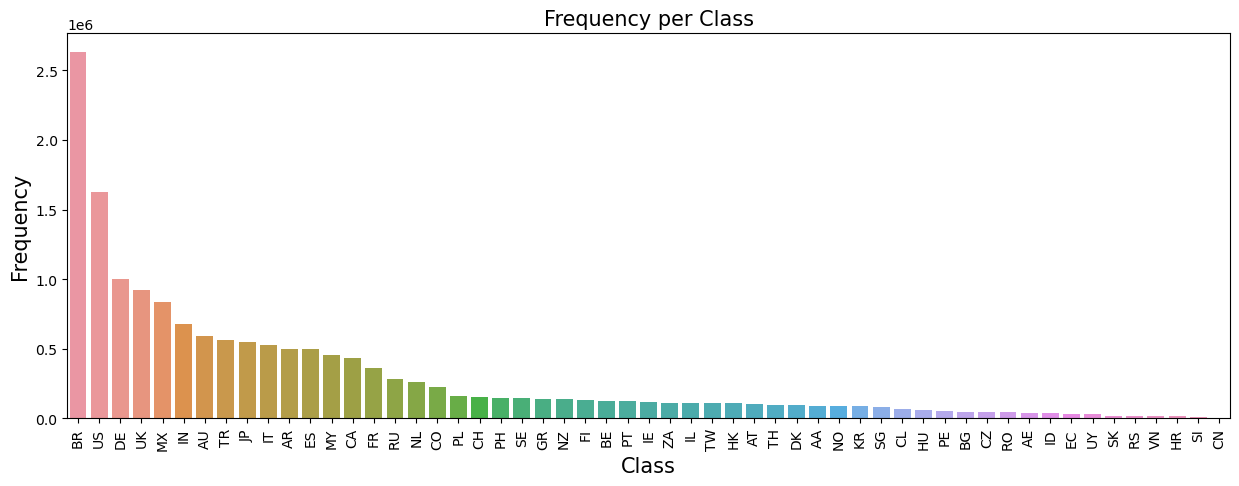

In [9]:
plt.figure(figsize = (15, 5))
sns.countplot(data=data, x='platform', order = data['platform'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Frequency per Platform', fontsize = 15)
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [10]:
data['device'].unique()

array(['mobile', 'desktop', 'tablet'], dtype=object)

### Columns to drop

#### a. Impressions
When impressions are not null, action type is always "clickout item"
Droping the column to ensure we don't have data leakage

In [11]:
impressions_filter = data[data['impressions'].notna()]
impressions_filter['action_type'].unique()

array(['clickout item'], dtype=object)

#### b. Prices
When prices are not null, action type is always "clickout item"
Droping the column to ensure we don't have data leakage

In [12]:
prices_filter = data[data['prices'].notna()]
prices_filter['action_type'].unique()

array(['clickout item'], dtype=object)

## Creating a manageable subset to work on  
Choosing 'BR' platform to initially work on - my memory cannot handle any more

In [13]:
data = data.loc[(data['platform'] == 'BR')]
data.shape
# subset_df = original_data.loc[(original_data['platform'] == 'UK')]
# # subset_df = original_data.loc[(original_data['platform'] == 'BR') | (original_data['platform'] == 'US')]
# subset_df.head()

(2634304, 12)

In [14]:
# subset_df.shape

## Getting the Filters

In [15]:
# subset_df[subset_df['current_filters'].notna()]

In [16]:
# subset_df.loc[subset_df['current_filters'] != '', 'current_filters'].unique()

In [17]:
# unique_filters = set()

# for item in subset_df['current_filters']:
#     if pd.notna(item):
#         for value in item.split('|'):
#             unique_filters.add(value)
# unique_filters = list(unique_filters)

# print(unique_filters)

In [18]:
# len(unique_filters)

In [19]:
# expanded_filters_df = pd.DataFrame(index = subset_df.index, columns = unique_filters)

# expanded_filters_df = expanded_filters_df.fillna(0)

# update_values = lambda row: [expanded_filters_df.at[row.name, value] if isinstance(row['current_filters'], str) and value in row['current_filters'].split('|') else 0 for value in expanded_filters_df.columns]

# # Apply the lambda function row-wise to subset_df
# expanded_filters_df = subset_df.apply(update_values, axis=1, result_type='expand')

# # for value in unique_filters:
# #     expanded_filters_df[value] = 0
# #     expanded_filters_df.loc[subset_df['current_filters'].apply(lambda x: value in x if isinstance(x, list) else False), value] = 1

# expanded_filters_df.head()

In [20]:
# subset_df = subset_df.join(expanded_filters_df)

In [21]:
# subset_df.drop(columns=['current_filters'], inplace=True)

In [22]:
# subset_df[subset_df['current_filters'].notna()]

In [85]:
data.head(5)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
16,02HGRBA06ODU,fa3a53156ae5c,1541030832,1,interaction item info,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
17,02HGRBA06ODU,fa3a53156ae5c,1541030843,2,interaction item image,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
18,02HGRBA06ODU,fa3a53156ae5c,1541030843,3,interaction item image,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
19,02HGRBA06ODU,fa3a53156ae5c,1541030852,4,interaction item info,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
20,02HGRBA06ODU,fa3a53156ae5c,1541030867,5,interaction item info,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN


## Feature Engineering
Transforming the orginal dataset to a new_df that will have information per session

In [23]:
## Starting with our classes, the request here is whether there was at least one clickout item or not.
## So we assign value 1 if the clickout items were one or more & 0 if there were no clickouit items.

def clickout_item_counts(data):
    clickout_item_count = (data['action_type'] == 'clickout item').sum()
    
    return 1 if clickout_item_count >= 1 else 0

In [24]:
## Checking if for every session_id we always have a single platform
data.groupby('session_id')['platform'].nunique().sort_values(ascending = False).head()
## Hypothesis true

session_id
0000d4284ff9b    1
ab6f26497cad0    1
ab6ed152e7ccb    1
ab6ded5b5da6e    1
ab6de5a6ed57a    1
Name: platform, dtype: int64

In [25]:
## Will extract single platform for each session_id
def platform(data):
    platform = data['platform'].unique()[0]
    return platform

In [26]:
## Checking if for every session_id we always have a single device
data.groupby('session_id')['device'].nunique().sort_values(ascending = False).head()
## Hypothesis true

session_id
0000d4284ff9b    1
ab6f26497cad0    1
ab6ed152e7ccb    1
ab6ded5b5da6e    1
ab6de5a6ed57a    1
Name: device, dtype: int64

In [27]:
## Will extract single device for each session_id
def device(data):
    device = data['device'].unique()[0]
    return device

In [28]:
## Checking if for every session_id we always have a single city
data.groupby('session_id')['city'].nunique().sort_values(ascending = False).head()
## Hypothesis false

session_id
d04447bcaa3de    39
b4d0f93ddd2e8    29
1ad58be069b61    27
89d19783b4f32    25
080e657bc4c9a    23
Name: city, dtype: int64

In [29]:
## Checking how many cities exist in the dataset
data['city'].nunique()

3023

In [30]:
## For cities since we have a huge count (even solely for BR platform) we will not create individual features for each city
## Instead we are keeping a metric for how many cities the user searched for in a specific session
def city_count(data):
    city_count = data['city'].nunique()
    
    return city_count

In [31]:
## Calculating sessions duration - since it's interval data we can take the substraction without converting

def session_duration(data):
    first_step_timestamp = data['timestamp'].min()
    last_step_timestamp = data['timestamp'].max()
    session_duration = last_step_timestamp - first_step_timestamp
    
    return session_duration

In [32]:
## Calculating total session steps

def steps_count(data):
    steps_count = data['step'].max()
    
    return steps_count

In [33]:
def interaction_item_rating_count(data):
    interaction_item_rating_count = (data['action_type'] == 'interaction item rating').sum()
    
    return interaction_item_rating_count

In [34]:
def interaction_item_info_count(data):
    interaction_item_info_count = (data['action_type'] == 'interaction item info').sum()
    
    return interaction_item_info_count

In [35]:
def interaction_item_image_count(data):
    interaction_item_image_count = (data['action_type'] == 'interaction item image').sum()
    
    return interaction_item_image_count

In [36]:
def interaction_item_deals_count(data):
    interaction_item_deals_count = (data['action_type'] == 'interaction item deals').sum()
    
    return interaction_item_deals_count

In [37]:
def change_of_sort_order_count(data):
    change_of_sort_order_count = (data['action_type'] == 'change of sort order').sum()
    
    return change_of_sort_order_count

In [38]:
def filter_selection_count(data):
    filter_selection_count = (data['action_type'] == 'filter selection').sum()
    
    return filter_selection_count

In [39]:
def search_for_item_count(data):
    search_for_item_count = (data['action_type'] == 'search for item').sum()
    
    return search_for_item_count

In [40]:
def search_for_destination_count(data):
    search_for_destination_count = (data['action_type'] == 'search for destination').sum()
    
    return search_for_destination_count

In [41]:
def search_for_poi_count(data):
    search_for_poi_count = (data['action_type'] == 'search for poi').sum()
    
    return search_for_poi_count

In [42]:
## Simply calculating if a user used a filter within a specific session or not - trying to find another way but I either don't have the memory or it's not working
## Actually not keeping even this since we have action_type filter selection

def filters_used(data):
    if data['current_filters'].notna().any():
        return 1
    else:
        return 0

In [43]:
def transformation(data): 
    
    metrics = {
        'Clickout_Item_Counts': clickout_item_counts(data),
        'Platform': platform(data),
        'Device': device(data),
        'City_Count': city_count(data),
        'Session_Duration': session_duration(data),
        'Steps_Count': steps_count(data),
        'Interaction_Item_Rating_Count': interaction_item_rating_count(data),
        'Interaction_Item_Image_Count': interaction_item_image_count(data),
        'Interaction_Item_Deals_Count': interaction_item_deals_count(data),
        'Change_of_Sort_Order_Count': change_of_sort_order_count(data),
        'Filter_Selection_Count': filter_selection_count(data),
        'Search_for_Item_Count': search_for_item_count(data),
        'Search_for_Destination_Count': search_for_destination_count(data),
        'Search_for_Poi_Count': search_for_poi_count(data)        
    }
    return pd.Series(metrics)

## Final Dataset

In [44]:
new_df = data.groupby(['user_id', 'session_id']).apply(transformation)

In [45]:
new_df.head()

Clickout_Item_Counts Platform   Device  \
user_id      session_id                                              
0001VQMGUI65 466687f1875ee                     1       BR  desktop   
0008BO33KUQ0 298103812b153                     0       BR   mobile   
             d4c5cc7f469d7                     1       BR   mobile   
             eaae649fbd8c9                     1       BR   mobile   
0024WQMRS5XT aeb39b3ea97d8                     1       BR   mobile   

                            City_Count  Session_Duration  Steps_Count  \
user_id      session_id                                                 
0001VQMGUI65 466687f1875ee           1               484           18   
0008BO33KUQ0 298103812b153           2               490           33   
             d4c5cc7f469d7           2              2163           12   
             eaae649fbd8c9           2               974            7   
0024WQMRS5XT aeb39b3ea97d8           1               723            3   

                            Interaction_Item_Rating_Count  \
user_id      session_id                                     
0001VQMGUI65 466687f1875ee                              1   
0008BO33KUQ0 298103812b153                              1   
             d4c5cc7f469d7                              0   
             eaae649fbd8c9                              0   
0024WQMRS5XT aeb39b3ea97d8                              0   

                            Interaction_Item_Image_Count  \
user_id      session_id                                    
0001VQMGUI65 466687f1875ee                             2   
0008BO33KUQ0 298103812b153                            27   
             d4c5cc7f469d7                             0   
             eaae649fbd8c9                             0   
0024WQMRS5XT aeb39b3ea97d8                             0   

                            Interaction_Item_Deals_Count  \
user_id      session_id                                    
0001VQMGUI65 466687f1875ee                             5   
0008BO33KUQ0 298103812b153                             0   
             d4c5cc7f469d7                             0   
             eaae649fbd8c9                             0   
0024WQMRS5XT aeb39b3ea97d8                             0   

                            Change_of_Sort_Order_Count  \
user_id      session_id                                  
0001VQMGUI65 466687f1875ee                           2   
0008BO33KUQ0 298103812b153                           0   
             d4c5cc7f469d7                           0   
             eaae649fbd8c9                           0   
0024WQMRS5XT aeb39b3ea97d8                           0   

                            Filter_Selection_Count  Search_for_Item_Count  \
user_id      session_id                                                     
0001VQMGUI65 466687f1875ee                       1                      0   
0008BO33KUQ0 298103812b153                       2                      0   
             d4c5cc7f469d7                       2                      0   
             eaae649fbd8c9                       0                      0   
0024WQMRS5XT aeb39b3ea97d8                       0                      0   

                            Search_for_Destination_Count  Search_for_Poi_Count  
user_id      session_id                                                         
0001VQMGUI65 466687f1875ee                             0                     0  
0008BO33KUQ0 298103812b153                             1                     1  
             d4c5cc7f469d7                             3                     3  
             eaae649fbd8c9                             4                     1  
0024WQMRS5XT aeb39b3ea97d8                             1                     0

In [46]:
new_df.shape

(110380, 14)

In [47]:
features = pd.DataFrame({
    'Count': new_df.count(),
    'Unique': new_df.nunique(),
    'Unique Percent': round(((new_df.nunique()/ new_df.count()) * 100),2),
    'Null Count': new_df.isnull().sum(),
    'Null Percent': new_df.isna().sum()* 100 / new_df.shape[0],
    'Data Type': new_df.dtypes
})
features

,Count,Unique,Unique Percent,Null Count,Null Percent,Data Type
Clickout_Item_Counts,110380,2,0.00,0,0.0,int64
Platform,110380,1,0.00,0,0.0,object
Device,110380,3,0.00,0,0.0,object
City_Count,110380,25,0.02,0,0.0,int64
Session_Duration,110380,5675,5.14,0,0.0,int64
Steps_Count,110380,699,0.63,0,0.0,int64
Interaction_Item_Rating_Count,110380,32,0.03,0,0.0,int64
Interaction_Item_Image_Count,110380,667,0.60,0,0.0,int64
Interaction_Item_Deals_Count,110380,34,0.03,0,0.0,int64
Change_of_Sort_Order_Count,110380,30,0.03,0,0.0,int64


Will not be using user_id & session_id since they are highly unique - instead we will set them as index

In [48]:
new_df.describe()

,Clickout_Item_Counts,City_Count,Session_Duration,Steps_Count,Interaction_Item_Rating_Count,Interaction_Item_Image_Count,Interaction_Item_Deals_Count,Change_of_Sort_Order_Count,Filter_Selection_Count,Search_for_Item_Count,Search_for_Destination_Count,Search_for_Poi_Count
count,110380.00,110380.00,110380.00,110380.00,110380.00,110380.00,110380.00,110380.00,110380.00,110380.00,110380.00,110380.00
mean,0.88,1.25,582.18,23.86,0.32,19.34,0.22,0.41,0.63,0.21,0.51,0.13
std,0.32,0.82,1865.76,59.32,1.08,56.61,0.86,1.36,2.62,0.77,1.13,0.49
min,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,14.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,141.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,554.00,21.00,0.00,15.00,0.00,0.00,0.00,0.00,1.00,0.00
max,1.00,39.00,177062.00,1977.00,60.00,1762.00,54.00,42.00,145.00,51.00,153.00,27.00


In [86]:
## Checking for duplicates
print(new_df.shape) 
df_drop_dup = new_df.drop_duplicates()
print(df_drop_dup.shape)
## No duplicates

(110380, 14)
(71916, 14)


1    63184
0     8732
Name: Clickout_Item_Counts, dtype: int64

In [50]:
new_df['Clickout_Item_Counts'].value_counts()

1    97559
0    12821
Name: Clickout_Item_Counts, dtype: int64

Text(0, 0.5, 'Frequency')

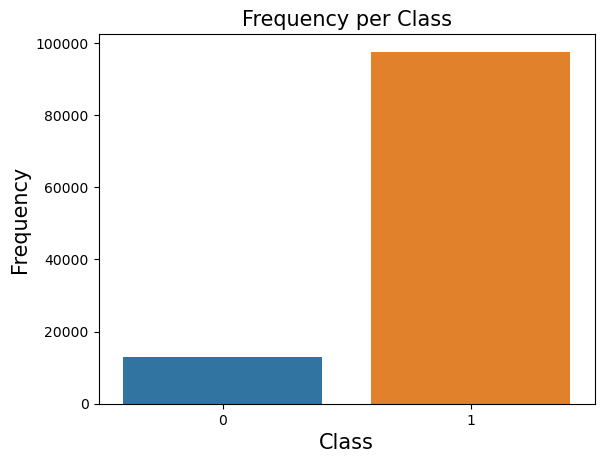

In [51]:
sns.countplot(data = new_df, x = 'Clickout_Item_Counts')
plt.title('Frequency per Class', fontsize = 15)
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

Unbalanced dataset

## Balancing the Data
Since we have the luxury of ample data, and my memory cannot suffer the full 100000, let's create a balanced dataset 

In [52]:
class1 = new_df[new_df['Clickout_Item_Counts'] == 1]
class0 = new_df[new_df['Clickout_Item_Counts'] == 0]
print(class1.shape)
print(class0.shape)

(97559, 14)
(12821, 14)


In [53]:
sample_class1 = resample(
    class1, 
    n_samples = 5000, 
    replace = False,
    random_state = 1
    )

In [54]:
sample_class0 = resample(
    class0, 
    n_samples = 5000, 
    replace = False,
    random_state = 1
    )

In [55]:
balanced_df = pd.concat([sample_class1, sample_class0])

## Final Dataset EDA

In [56]:
balanced_df['Clickout_Item_Counts'].value_counts()

1    5000
0    5000
Name: Clickout_Item_Counts, dtype: int64

Text(0, 0.5, 'Frequency')

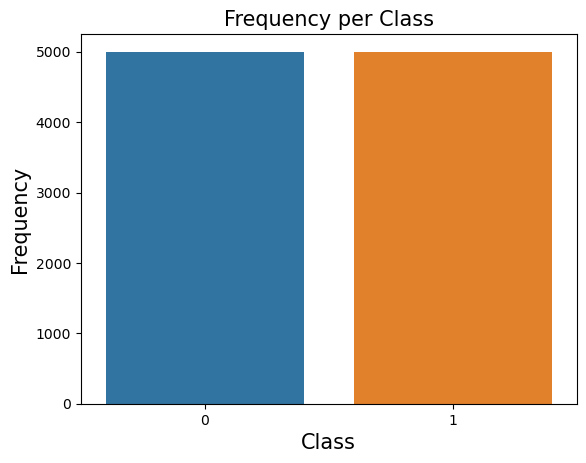

In [57]:
sns.countplot(data = balanced_df, x = 'Clickout_Item_Counts')
plt.title('Frequency per Class', fontsize = 15)
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

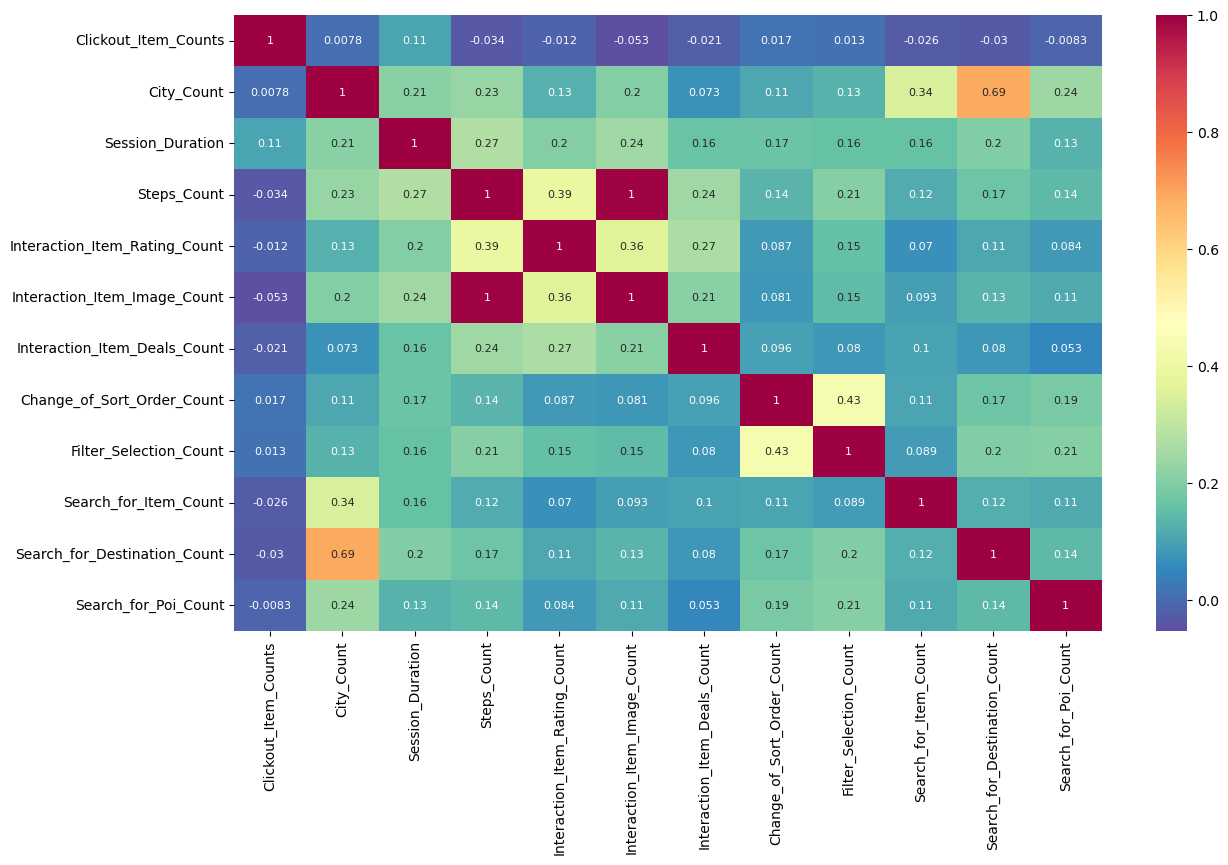

In [58]:
corr_matrix = balanced_df.corr()

f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            annot_kws={'size': 8}, 
            cmap="Spectral_r");

In [59]:
features = pd.DataFrame({
    'Count': balanced_df.count(),
    'Unique': balanced_df.nunique(),
    'Unique Percent': round(((balanced_df.nunique()/ balanced_df.count()) * 100),2),
    'Null Count': balanced_df.isnull().sum(),
    'Null Percent': balanced_df.isna().sum()* 100 / balanced_df.shape[0],
    'Data Type': balanced_df.dtypes
})
features

,Count,Unique,Unique Percent,Null Count,Null Percent,Data Type
Clickout_Item_Counts,10000,2,0.02,0,0.0,int64
Platform,10000,1,0.01,0,0.0,object
Device,10000,3,0.03,0,0.0,object
City_Count,10000,14,0.14,0,0.0,int64
Session_Duration,10000,1905,19.05,0,0.0,int64
Steps_Count,10000,316,3.16,0,0.0,int64
Interaction_Item_Rating_Count,10000,16,0.16,0,0.0,int64
Interaction_Item_Image_Count,10000,301,3.01,0,0.0,int64
Interaction_Item_Deals_Count,10000,18,0.18,0,0.0,int64
Change_of_Sort_Order_Count,10000,18,0.18,0,0.0,int64


In [60]:
X = balanced_df.drop('Clickout_Item_Counts', axis=1)
y = balanced_df['Clickout_Item_Counts']
print ("X dimensions: ", X.shape)
print ("y dimensions: ", y.shape)

X dimensions:  (10000, 13)
y dimensions:  (10000,)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    stratify = y,
                                                    random_state = 1)
print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

Shape of x_train and y_train:  (7000, 13) (7000,)
Shape of x_test and y_test:  (3000, 13) (3000,)


## Categorical & Numerical Preprocessing

In [62]:
X_train_numerical = X_train.select_dtypes(include = np.number)
X_train_categorical = X_train.select_dtypes(include = 'object')
X_test_numerical = X_test.select_dtypes(include = np.number)
X_test_categorical = X_test.select_dtypes(include = 'object')

print(X_train_numerical.columns)
print(X_train_categorical.columns)
print(X_test_numerical.columns)
print(X_test_categorical.columns)

Index(['City_Count', 'Session_Duration', 'Steps_Count',
       'Interaction_Item_Rating_Count', 'Interaction_Item_Image_Count',
       'Interaction_Item_Deals_Count', 'Change_of_Sort_Order_Count',
       'Filter_Selection_Count', 'Search_for_Item_Count',
       'Search_for_Destination_Count', 'Search_for_Poi_Count'],
      dtype='object')
Index(['Platform', 'Device'], dtype='object')
Index(['City_Count', 'Session_Duration', 'Steps_Count',
       'Interaction_Item_Rating_Count', 'Interaction_Item_Image_Count',
       'Interaction_Item_Deals_Count', 'Change_of_Sort_Order_Count',
       'Filter_Selection_Count', 'Search_for_Item_Count',
       'Search_for_Destination_Count', 'Search_for_Poi_Count'],
      dtype='object')
Index(['Platform', 'Device'], dtype='object')


#### Scaling Numerical Features

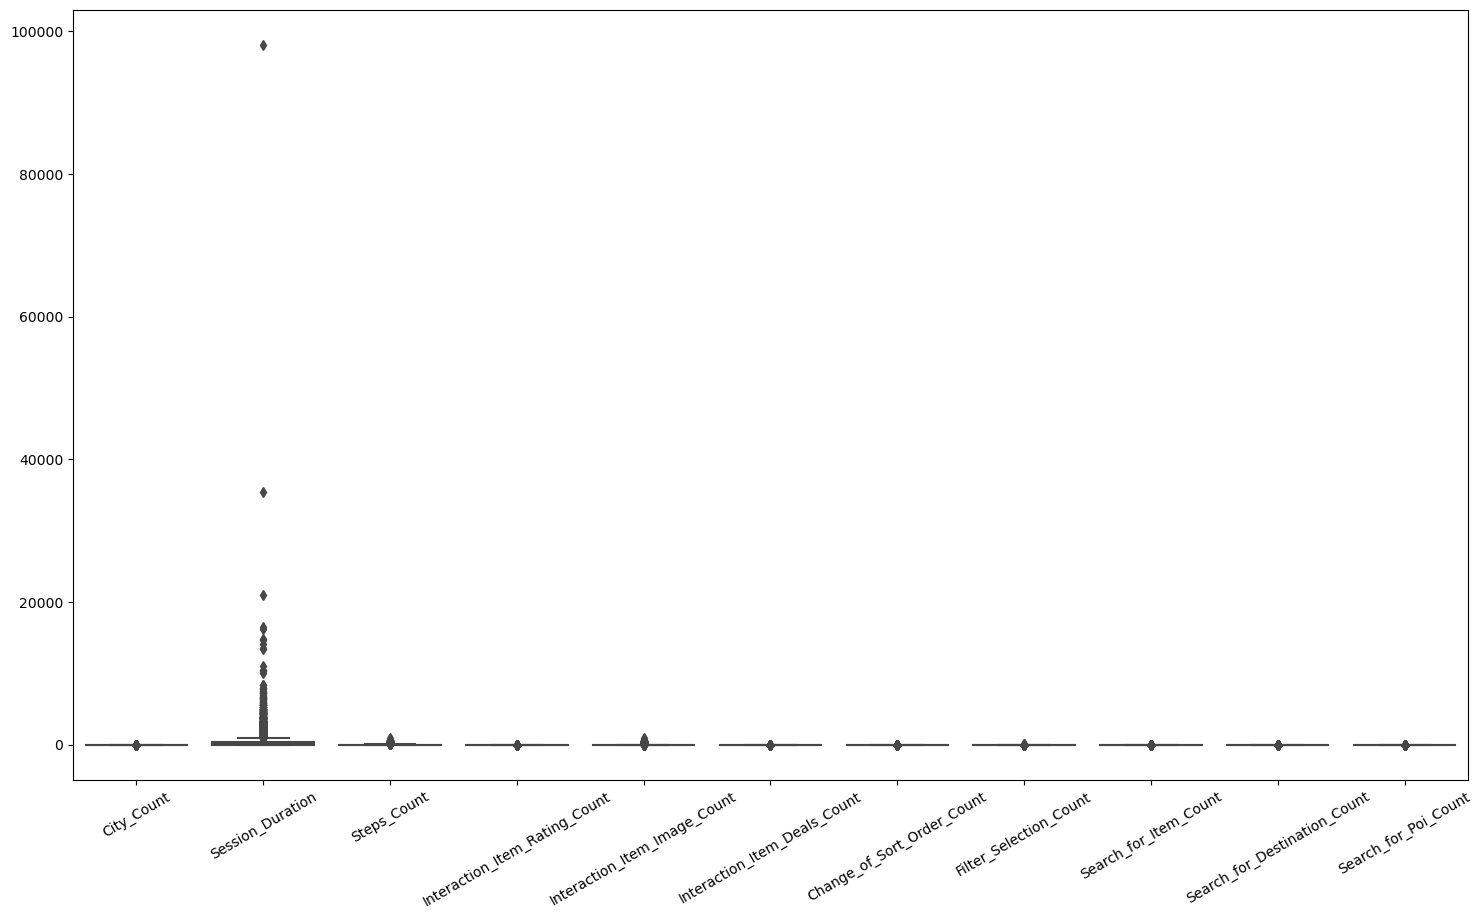

In [63]:
plt.figure(figsize=(18,10))
ax = sns.boxplot(data=X_train_numerical)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

In [64]:
scaler = MinMaxScaler()
X_train_numerical = pd.DataFrame(scaler.fit_transform(X_train_numerical), index = X_train_numerical.index, columns = X_train_numerical.columns)
X_test_numerical  = pd.DataFrame(scaler.transform(X_test_numerical), index = X_test_numerical.index, columns = X_test_numerical.columns)

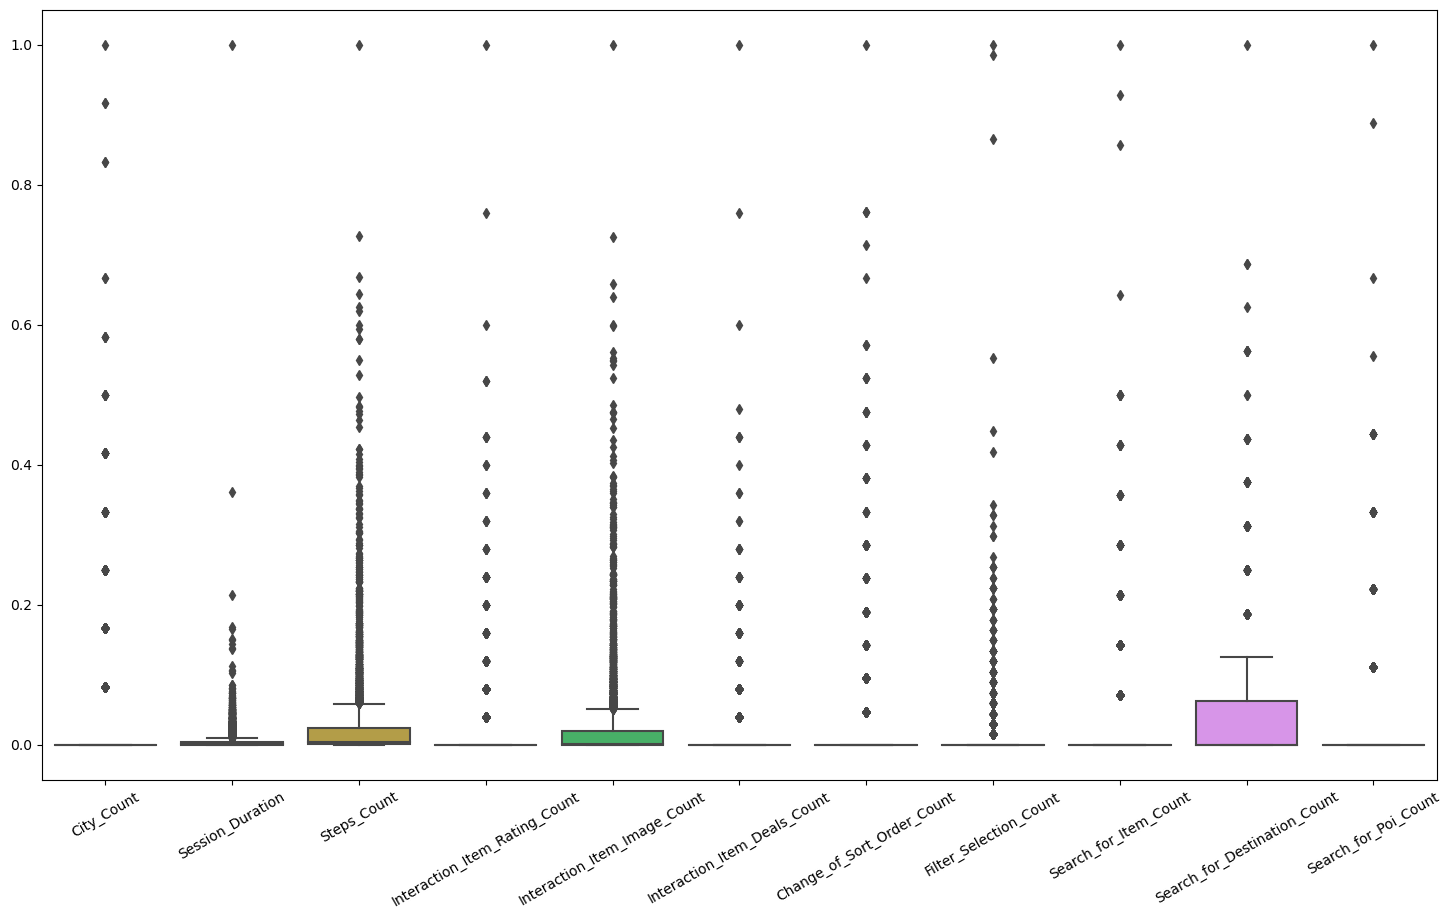

In [65]:
plt.figure(figsize = (18, 10))
ax = sns.boxplot(data = X_train_numerical)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.show();

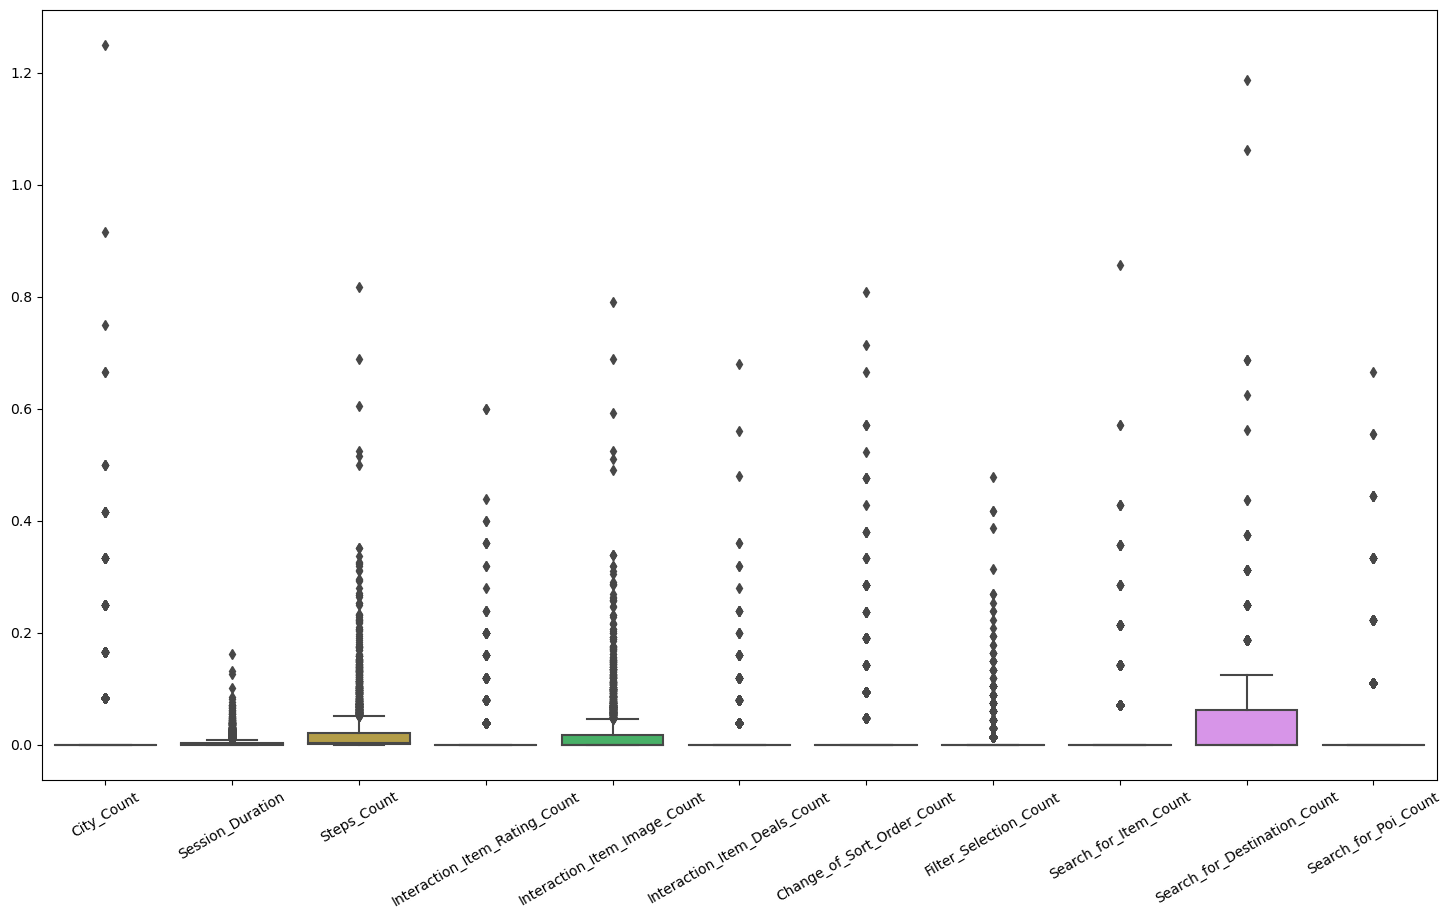

In [66]:
plt.figure(figsize = (18, 10))
ax = sns.boxplot(data = X_test_numerical)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.show();

#### One-Hot-Encoding Categorical Features

In [68]:
X_train_categorical = pd.get_dummies(X_train_categorical)
X_test_categorical = pd.get_dummies(X_test_categorical)
print(X_train_categorical.head(2))
print(X_test_categorical.head(2))

                            Platform_BR  Device_desktop  Device_mobile  \
user_id      session_id                                                  
IFSCX48E2NQZ 75e89544bd4e1            1               0              1   
38R75739KOXJ 3d61dd9e7a1bf            1               0              1   

                            Device_tablet  
user_id      session_id                    
IFSCX48E2NQZ 75e89544bd4e1              0  
38R75739KOXJ 3d61dd9e7a1bf              0  
                            Platform_BR  Device_desktop  Device_mobile  \
user_id      session_id                                                  
M2FX9D002SM9 da269929464e1            1               1              0   
52CRNRK9J7QI a9d4026eb5b0e            1               0              1   

                            Device_tablet  
user_id      session_id                    
M2FX9D002SM9 da269929464e1              0  
52CRNRK9J7QI a9d4026eb5b0e              0  


#### Joining the Features Again

In [69]:
X_train = X_train_categorical.join(X_train_numerical)
X_test = X_test_categorical.join(X_test_numerical)
print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

Shape of x_train and y_train:  (7000, 15) (7000,)
Shape of x_test and y_test:  (3000, 15) (3000,)


## Models

In [70]:
clf_results = pd.DataFrame([])

### 1. Neural Network

In [71]:
parameter_space_NN = {
    'hidden_layer_sizes': [(5,), (10,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'batch_size': [10 , 20],
    'tol': [1e-7],
    'learning_rate': ['constant','adaptive'],
}

In [72]:
clf_NN = MLPClassifier(random_state = 1,
                       max_iter = 5000,
                       verbose = False,
                       validation_fraction = 0.1
                      )

In [73]:
NN = GridSearchCV(estimator = clf_NN,
                  param_grid = parameter_space_NN,
                  n_jobs = -1,
                  cv = 5)

In [74]:
NN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=5000, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05], 'batch_size': [10, 20],
                         'hidden_layer_sizes': [(5,), (10,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam'], 'tol': [1e-07]})

In [75]:
print("Best score: ", NN.best_score_)
print("Best parameters: ", NN.best_params_)
print("Best estimator: ", NN.best_estimator_)

Best score:  0.866
Best parameters:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 20, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'adam', 'tol': 1e-07}
Best estimator:  MLPClassifier(batch_size=20, hidden_layer_sizes=(10,), max_iter=5000,
              random_state=1, tol=1e-07)


In [76]:
y_train_pred_NN = NN.predict (X_train)

In [77]:
y_test_pred_NN = NN.predict (X_test)

In [78]:
clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'Neural Network', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_test_pred_NN), 3), 
                                                         'F1_macro': round(metrics.f1_score(y_test, y_test_pred_NN, average='macro'), 3)})])
clf_results

,Model,Accuracy,F1_macro
0,Neural Network,0.85,0.85


Neural Network: Confusion matrix Train Set
[[3101  399]
 [ 524 2976]]

Neural Network: Confusion matrix Test Set
[[1317  183]
 [ 256 1244]]



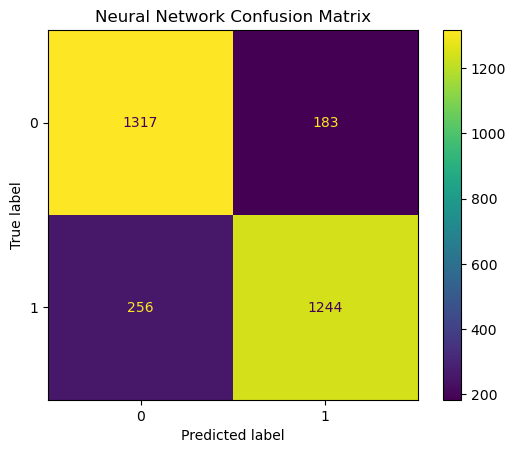

In [79]:
# Neural Network

confMatrixTrainNN = confusion_matrix(y_train, y_train_pred_NN, labels = None)
confMatrixTestNN = confusion_matrix(y_test, y_test_pred_NN, labels = None)

print ('Neural Network: Confusion matrix Train Set')
print (confMatrixTrainNN)
print ()

print ('Neural Network: Confusion matrix Test Set')
print (confMatrixTestNN)
print ()

ConfusionMatrixDisplay(confusion_matrix=confMatrixTestNN).plot()
plt.title('Neural Network Confusion Matrix')
plt.show()

In [80]:
# Neural Network

print ('Neural Network: Classification Report')
print(classification_report(y_test, y_test_pred_NN))

Neural Network: Classification Report
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1500
           1       0.87      0.83      0.85      1500

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



In [81]:
# Neural Network

# First we compute the probability for the classes (test set)
pr_y_test_pred_NN = NN.predict_proba(X_test)
fprNN, tprNN, thresholdsNN = roc_curve(y_test, pr_y_test_pred_NN[:,1])
roc_curve(y_test, pr_y_test_pred_NN[:,1])

(array([0.00000000e+00, 6.66666667e-04, 6.66666667e-04, 1.33333333e-03,
        1.33333333e-03, 2.00000000e-03, 2.00000000e-03, 2.66666667e-03,
        2.66666667e-03, 2.66666667e-03, 2.66666667e-03, 2.66666667e-03,
        2.66666667e-03, 3.33333333e-03, 3.33333333e-03, 4.00000000e-03,
        4.00000000e-03, 4.66666667e-03, 4.66666667e-03, 5.33333333e-03,
        5.33333333e-03, 6.00000000e-03, 6.00000000e-03, 6.66666667e-03,
        6.66666667e-03, 6.66666667e-03, 6.66666667e-03, 7.33333333e-03,
        7.33333333e-03, 8.00000000e-03, 8.00000000e-03, 8.66666667e-03,
        8.66666667e-03, 8.66666667e-03, 8.66666667e-03, 8.66666667e-03,
        8.66666667e-03, 8.66666667e-03, 8.66666667e-03, 8.66666667e-03,
        9.33333333e-03, 9.33333333e-03, 1.06666667e-02, 1.06666667e-02,
        1.13333333e-02, 1.13333333e-02, 1.20000000e-02, 1.20000000e-02,
        1.26666667e-02, 1.26666667e-02, 1.33333333e-02, 1.33333333e-02,
        1.40000000e-02, 1.40000000e-02, 1.46666667e-02, 1.466666

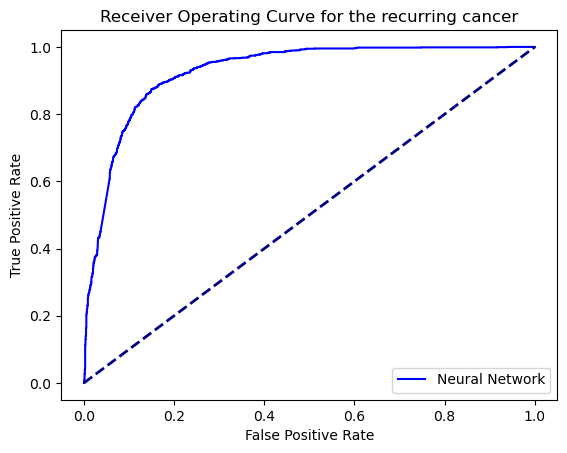

AUC_NN =  0.926757111111111


In [82]:
lw=2
plt.plot(fprNN, tprNN, color = 'blue', label = 'Neural Network')
# plt.plot(fprDT, tprDT, color = 'red', label = 'Decision Tree')
# plt.plot(fprKNN, tprKNN, color = 'green', label = 'K-Nearest Neighbor')
# plt.plot(fprNB, tprNB, color = 'yellow', label = 'Naive Bayes')
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve for the recurring cancer')
plt.legend(loc = "lower right")
plt.show()
print ('AUC_NN = ',metrics.auc(fprNN, tprNN))
# print ('AUC_DT = ',metrics.auc(fprDT, tprDT))
# print ('AUC_KNN = ',metrics.auc(fprKNN, tprKNN))
# print ('AUC_NB = ',metrics.auc(fprNB, tprNB))